# 使用 Keras 搭建人工神经网络

### 一、查看 tensorflow 是否安装成功

In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [41]:
tf.__version__

'2.6.0'

In [42]:
keras.__version__

'2.6.0'

### 二、使用 Keras 加载数据集

Keras 提供一些实用的函数用来获取和加载常见的数据集，包括 MNIST、Fashion MNIST 和第 2 章用过的加州房产数据集。加载 Fashion MNIST：

In [43]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

当使用 Keras 加载 MNIST 或 Fashion MNIST 时，和 Scikit-Learn 加载数据的一个重要区别是，每张图片是28 × 28的数组，而不是大小是 784 的 1D 数组。另外像素的强度是用整数（0 到 255）表示的，而不是浮点数（0.0 到 255.0）。看下训练集的形状和类型：

In [44]:
X_train_full.shape

(60000, 28, 28)

In [45]:
X_train_full.dtype

dtype('uint8')

该数据集已经分成了训练集和测试集，但没有验证集。所以要建一个验证集，另外，因为要用梯度下降训练神经网络，必须要对输入特征进行缩放。简单起见，通过除以 255.0 将强度范围变为 0-1：

In [46]:
X_valid,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_valid,y_train = y_train_full[:5000],y_train_full[5000:]

对于 MNIST，当标签等于 5 时，表明图片是手写的数字 5。但对于 Fashion MNIST，需要分类名的列表：

In [47]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] 

例如，训练集的第一张图片表示外套：

In [48]:
class_names[y_train[0]]

'Coat'

### 三、用顺序 API 创建模型

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

逐行看下代码：

* 第一行代码创建了一个顺序 模型，这是 Keras 最简单的模型，是由单层神经元顺序连起来的，被称为顺序 API；


* 接下来创建了第一层，这是一个 `Flatten层` ，它的作用是将每个输入图片转变为 1D 数组：如果输入数据是 `X`，该层则计算 `X.reshape(-1, 1)`。该层没有任何参数，只是做一些简单预处理。因为是模型的第一层，必须要指明 `input_shape`，`input_shape` 不包括批次大小，只是实例的形状。另外，第一层也可以是 `keras.layers.InputLayer`，设置 `input_shape=[28,28]`;


* 然后，添加了一个有 300 个神经元的紧密层，激活函数是 ReLU。每个紧密层只负责自身的权重矩阵，权重矩阵是神经元与输入的所有连接权重。紧密层还要负责偏置项（每个神经元都有一个偏置项）向量。当紧密层收到输入数据时，就利用如下公式进行计算：

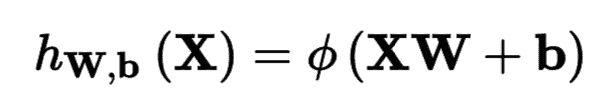

* 接着再添加第二个紧密层，激活函数仍然是 ReLU；


* 最后，加上一个拥有 10 个神经元的输出层（每有一个类就要有一个神经元），激活函数是 softmax（保证输出的概率和等于 1，因为就只有这是个类，具有排他性）。

模型的 `summary()` 方法可以展示所有层，包括每个层的名字（名字是自动生成的，除非建层时指定名字），输出的形状（ `None` 代表批次大小可以是任意值），和参数的数量。最后会输出所有参数的数量，包括可训练和不可训练参数。

这章只有可训练参数（第 11 章可以看到不可训练参数的例子）：

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


紧密层通常有许多参数。比如，第一个隐含层有 `784 × 300` 个连接权重，再加上 `300` 个偏置项，总共有 `235500` 个参数。这么多参数可以让模型具有足够的灵活度以拟合训练数据，但也意味着可能有过拟合的风险，特别是当训练数据不足时。后面再讨论这个问题。

使用属性，获取神经层很容易，可以通过索引或名称获取对应的层：

In [51]:
model.layers

In [55]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [59]:
# model.get_layer('Dense') is hidden1

可以用 `get_weights()` 和 `set_weights()` 方法，获取神经层的所有参数。对于紧密层，参数包括 `连接权重` 和 `偏置项`：

In [60]:
weights,biases = hidden1.get_weights()
weights

array([[ 0.0506734 , -0.03481189,  0.00636576, ..., -0.03400098,
         0.05607569, -0.03619579],
       [-0.00203162, -0.06638727, -0.0622946 , ..., -0.01013738,
         0.04081945, -0.03143887],
       [ 0.03648217,  0.03403071, -0.00610803, ..., -0.03554079,
        -0.05908823,  0.00303782],
       ...,
       [ 0.04547248, -0.00891829, -0.05069645, ...,  0.05558899,
        -0.02145936,  0.00691813],
       [ 0.05440122, -0.04474668, -0.05840728, ...,  0.01405205,
         0.02290952, -0.05056821],
       [-0.07394202,  0.02196636, -0.00073475, ..., -0.01964845,
        -0.05252707, -0.03077147]], dtype=float32)

In [61]:
weights.shape  # 参数 w

(784, 300)

In [62]:
biases.shape  # 偏置项 b

(300,)

紧密层是随机初始化连接权重的（为了避免对称性），偏置项则是 0。如果想使用不同的初始化方法，可以在创建层时设置 `kernel_initializer`（核是连接矩阵的另一个名字）或 `bias_initializer` 。第 11 章会进一步讨论初始化器，初始化器的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Finitializers%2F)。

#### 笔记：

权重矩阵的形状取决于输入的数量。这就是为什么要在创建 `Sequential模型` 的第一层时指定 `input_shape` 。但是，如果不指定形状也没关系：Keras 会在真正搭建模型前一直等待，直到弄清输入的形状（输入真实数据时，或调用 `build()` 方法时）。在搭建模型之前，神经层是没有权重的，也干不了什么事（比如打印模型概要或保存模型）。`所以如果在创建模型时知道输入的形状，最好就设置好。`

### 四、编译模型

创建好模型之后，必须调用 `compile()` 方法，设置损失函数和优化器。另外，还可以指定训练和评估过程中要计算的额外指标的列表：

In [63]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#### 笔记：

使用 `loss="sparse_categorical_crossentropy"` 等同于 `loss=keras.losses.sparse_categorical_crossentropy` 。

相似的，`optimizer="sgd"` 等同于 `optimizer=keras.optimizers.SGD()` ，`metrics=["accuracy"]` 等同于 `metrics=[keras.metrics.sparse_categorical_accuracy]`。

后面还会使用其他的 `损失函数` 、`优化器` 和 `指标`，它们的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Flosses)、 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Foptimizers)、和[这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Fmetrics。)

解释下这段代码。首先，因为使用的是稀疏标签（每个实例只有一个目标类的索引，在这个例子中，目标类索引是 0 到 9），且就是这十个类，没有其它的，所以使用的是 `"sparse_categorical_crossentropy"` 损失函数。如果每个实例的每个类都有一个目标概率（比如独热向量，`[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]` ，来表示类 3），则就要使用 `"categorical_crossentropy"` 损失函数。如果是做二元分类（有一个或多个二元标签），输出层就得使用 `"sigmoid"` 激活函数，损失函数则变为 `"binary_crossentropy"`。

### 五、训练和评估模型

可以训练模型了。只需调用 fit() 方法：

In [64]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7206 - accuracy: 0.7690 - val_loss: 0.5131 - val_accuracy: 0.8268
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4868 - accuracy: 0.8298 - val_loss: 0.4697 - val_accuracy: 0.8384
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4426 - accuracy: 0.8438 - val_loss: 0.4133 - val_accuracy: 0.8624
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4157 - accuracy: 0.8549 - val_loss: 0.3973 - val_accuracy: 0.8662
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3955 - accuracy: 0.8604 - val_loss: 0.4150 - val_accuracy: 0.8538
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3792 - accuracy: 0.8664 - val_loss: 0.4001 - val_accuracy: 0.8638
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3665 - accuracy: 0.8693 - val_loss: 0.3706 - val_accuracy:

这里，向 `fit()` 方法传递了输入特征 `(X_train)` 和目标类 `(y_train)`，还要要训练的周期数（不设置的话，默认的周期数是 1，肯定是不能收敛到一个好的解的）。另外还传递了验证集（它是可选的）。Keras 会在每个周期结束后，测量损失和指标，这样就可以监测模型的表现。如果模型在训练集上的表现优于在验证集上的表现，可能模型在训练集上就过拟合了（或者就是存在 bug，比如训练集和验证集的数据不匹配）。

#### 提示：

除了通过参数 `validation_data` 传递验证集，也可以通过参数 `validation_split` 从训练集分割出一部分作为验证集。比如，`validation_split=0.1` 可以让 `Keras` 使用训练数据（打散前）的末尾 10% 作为验证集。

如果训练集非常倾斜，一些类过渡表达，一些欠表达，在调用 `fit()` 时最好设置 `class_weight` 参数，可以加大欠表达类的权重，减小过渡表达类的权重。Keras 在计算损失时，会使用这些权重。如果每个实例都要加权重，可以设置 `sample_weight`（这个参数优先于 `class_weight` ）。如果一些实例的标签是通过专家添加的，其它实例是通过众包平台添加的，最好加大前者的权重，此时给每个实例都加权重就很有必要。通过在 `validation_data` 元组中，给验证集加上样本权重作为第三项，还可以给验证集添加样本权重。

`fit()` 方法会返回 `History` 对象，包含：`训练参数（history.params）` 、 `周期列表（history.epoch）`、以及最重要的包含训练集和验证集的每个周期后的损失和指标的字典 `（history.history）`。如果用这个字典创建一个 `pandas` 的 `DataFrame` ，然后使用方法 `plot()` ，就可以画出学习曲线，见图 ：

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# history.history #包含训练集和验证集的每个周期后的损失和指标的字典 

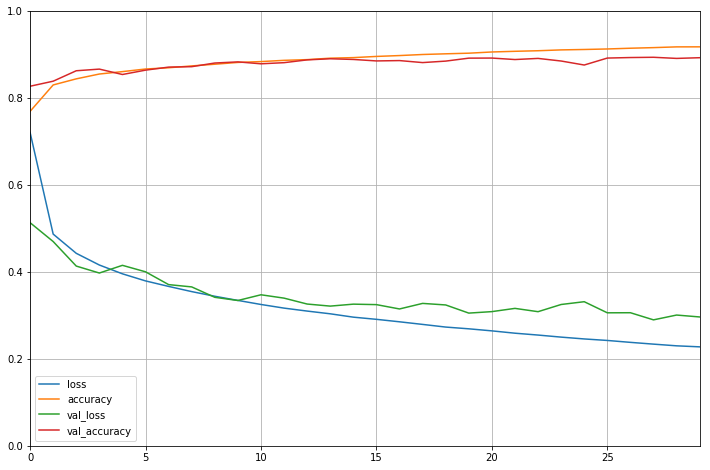

In [67]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True) # 是否加上网格
plt.gca().set_ylim(0,1)
plt.show()

记录了每个周期的平均训练损失和准确率，验证损失和准确率

可以看到，训练准确率和验证准确率稳步提高，训练损失和验证损失持续下降。另外，验证曲线和训练曲线靠的很近，意味着没有什么过拟合。在这个例子中，在训练一开始时，模型在验证集上的表现由于训练集。

`但实际情况是，验证误差是在每个周期结束后算出来的，而训练误差在每个周期期间，用流动平均误差算出来的。所以训练曲线（译者注，图中橙色的那条）实际应该向左移动半个周期。移动之后，就可以发现在训练开始时，训练和验证曲线几乎是完美重合起来的。`

#### 提示：

在绘制训练曲线时，应该向左移动半个周期。

通常只要训练时间足够长，训练集的表现就能超越验证集。从图中可以看到，验证损失仍然在下降，模型收敛的还不好，所以训练应该持续下去。只需要再次调用方法 `fit()` 即可，因为 Keras 可以从断点处继续（验证准确率可以达到 89%。）

如果仍然对模型的表现不满意，就需要调节超参数了。首先是学习率。如果调节学习率没有帮助，就尝试换一个优化器（记得再调节任何超参数之后都重新调节学习率）。如果效果仍然不好，就调节模型自身的超参数，比如层数、每层的神经元数，每个隐藏层的激活函数。还可以调节其它超参数，比如批次大小（通过 `fit()` 的参数 `batch_size` ，默认是 `32`）。本章末尾还会调节超参数。当对验证准确率达到满意之后，就可以用测试集评估 `泛化误差` 。只需使用 `evaluate()` 方法（`evaluate()` 方法包含参数 `batch_size` 和 `sample_weight`）：

一、经验误差（训练误差）与泛化误差

* 经验误差（训练误差）：模型在训练集上的误差称为“经验误差”（empirical error）或者“训练误差”“training error”。


* 泛化误差：模型在新样本集（测试集）上的误差称为“泛化误差”（generalization error）。


In [68]:
x_test = X_test/255.0

In [69]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3321 - accuracy: 0.8836


[0.3321235477924347, 0.8835999965667725]

### 5、使用模型进行预测

接下来，就可以用模型的predict()方法对新实例做预测了。因为并没有新实例，所以就用测试集的前 3 个实例来演示：

In [70]:
y_predict = model.predict(x_test[:3])
y_predict.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

可以看到，模型会对每个实例的每个类（从 0 到 9）都给出一个概率。

如果只关心概率最高的类（即使概率不高），可以使用方法 `predict_classes()：`

    y_predict_class = model.predict_classes(x_test[:3])
    y_predict_class

报错：

第一次用的网络是在model=Sequential()下添加模块的的方法，也就是所谓的顺序模型。Sequential class可以使用model.predict_classes()的方法来实现预测；

第二次用的方法，是编写好网络结构后使用model=Model()综合起来的方法，也就是Model class，无法使用model.predict_classes()，但是可以使用组合形式预测。

所以用下面写法替换：

In [71]:
y_predict_class=np.argmax(y_predict,axis=1)
y_predict_class

array([9, 2, 1], dtype=int64)

In [72]:
np.array(class_names)[y_predict_class]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [73]:
X_train[1].shape

(28, 28)

In [74]:
from PIL import Image

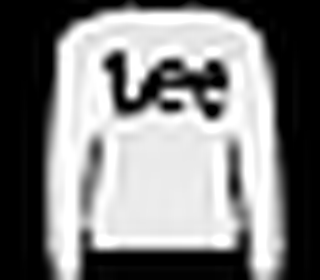

In [75]:
Image.fromarray(X_test[9].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 鞋子
Image.fromarray(X_test[2].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 裤子
Image.fromarray(X_test[1].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 👕

### 6、使用顺序 API 搭建回归 MLP

接下来使用回归神经网络来处理加州房价问题。简便起见，使用 `Scikit-Learn` 的 `fetch_california_housing()` 函数来加载数据。这个数据集比第 2 章所用的数据集简单，因为它只包括数值特征（没有 `ocean_proximity` ），也不包括缺失值。加载好数据之后，将数据集分割成训练集、验证集和测试集，并做特征缩放：

In [76]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [77]:
hoursing = fetch_california_housing()

x_train_full,x_test,y_train_full,y_test = train_test_split(hoursing.data,hoursing.target)
x_train,x_valid,y_train,y_valid = train_test_split(x_train_full,y_train_full) 

In [78]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_valid = ss.transform(x_valid)
x_test = ss.transform(x_test)

In [79]:
x_test[1]

array([-1.03573364,  1.14234604, -1.07141223, -0.20230783,  0.6177981 ,
        0.23566371, -0.7622662 ,  0.66299787])

In [80]:
x_train.shape

(11610, 8)

In [81]:
X_train.shape

(55000, 28, 28)

In [82]:
model = keras.models.Sequential(
    
    [
        keras.layers.Dense(30,activation='relu',input_shape=x_train.shape[1:]),
        keras.layers.Dense(1)
    ]
    )

model.compile(loss='mean_squared_error',optimizer='sgd')
history = model.fit(x_train,y_train,epochs=20,validation_data=(x_valid,y_valid))
mse_err = model.evaluate(x_test,y_test)
x_new = x_test[:3]
y_pre = model.predict(x_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8774 - val_loss: 0.5487
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5345 - val_loss: 0.5224
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7467 - val_loss: 0.4823
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4383 - val_loss: 0.4294
Epoch 5/20
363/363 [==============================] - 0s 997us/step - loss: 0.4155 - val_loss: 0.4185
Epoch 6/20
363/363 [==============================] - 0s 986us/step - loss: 0.4039 - val_loss: 0.4073
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3954 - val_loss: 0.4127
Epoch 8/20
363/363 [==============================] - 0s 967us/step - loss: 0.3912 - val_loss: 0.3914
Epoch 9/20
363/363 [==============================] - 0s 871us/step - loss: 0.3862 - val_loss: 0.3887
Epoch 10/20
363/363 [==============================] - 0s 788us/step - loss: 0.3844 - val_lo

In [83]:
mse_err

0.3725891411304474

In [84]:
y_test[:3]

array([2.544, 0.992, 0.728])

In [85]:
y_pre

array([[3.867567 ],
       [1.4029813],
       [0.6139164]], dtype=float32)

可以看到，使用顺序 API 是很方便的。但是，尽管Sequential十分常见，但用它搭建复杂拓扑形态或多输入多输出的神经网络还是不多。所以，Keras 还提供了函数式 API。

### 8、使用函数式 API 搭建复杂模型

我们来搭建一个这样的神经网络，来解决加州房价问题：
<div align=center><img  src="./static/使用函数式 API 搭建复杂模型1.jpg"/></div>


In [86]:
input_ = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation='relu')(input_)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_,hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_],outputs=[output])

每行代码的作用：

* 首先创建一个Input对象。包括模型输入的形状shape和数据类型dtype。模型可能会有多种输入。


* 然后，创建一个有 30 个神经元的紧密层，激活函数是 ReLU。创建好之后，将其作为函数，直接将输入传给它。这就是函数式 API 的得名原因。这里只是告诉 Keras 如何将层连起来，并没有导入实际数据。


* 然后创建第二个隐藏层，还是将其作为函数使用，输入时第一个隐藏层的输出；


* 接着，创建一个连接Concatenate层，也是作为函数使用，将输入和第二个隐藏层的输出连起来。可以使用keras.layers.concatenate()。


* 然后创建输出层，只有一个神经元，没有激活函数，将连接层的输出作为输入。


* 最后，创建一个 Keras 的Model，指明输入和输出。

搭建好模型之后，重复之前的步骤：编译模型、训练、评估、做预测。

但是如果你想将部分特征发送给 wide 路径，将部分特征（可以有重叠）发送给 deep 路径，该怎么做呢？答案是可以使用多输入。例如，`假设向 wide 路径发送 5 个特征（特征 0 到 4）`，`向 deep 路径发送 6 个特征（特征 2 到 7）`：

<div align=center><img  src="./static/使用函数式 API 搭建复杂模型2.jpg"/></div>


In [87]:
input_A = keras.layers.Input(shape=[5],name='wide_input')
input_B = keras.layers.Input(shape=[6],name='deep_input')
hidden1 = keras.layers.Dense(30,activation='relu')(input_B)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A,hidden2])
output = keras.layers.Dense(1,name='output')(concat)
model = keras.Model(inputs = [input_A,input_B],outputs=[output])

代码非常浅显易懂。值得注意的是，在创建模型时，我们指明了 `inputs=[input_A, input_B]` 。然后就可以像通常那样编译模型了，但当调用 `fit()` 时，不是传入矩阵 `X_train` ，而是传入一对矩阵 `(X_train_A, X_train_B)` ：每个输入一个矩阵。同理调用 `evaluate()` 或 `predict()` 时，`X_valid、X_test、X_new` 也要变化：

In [88]:
model.compile(loss='mse',optimizer=keras.optimizers.SGD(lr=1e-3))
x_train_A,x_train_B = x_train[:,:5],x_train[:,2:]
x_valid_A,x_valid_B = x_valid[:,:5],x_valid[:,2:]
x_test_A,x_test_B = x_test[:,:5],x_test[:,2:]
x_new_A,x_new_B = x_test_A[:3],x_test_B[:3]
history = model.fit((x_train_A,x_train_B),y_train,epochs=20,validation_data=((x_valid_A,x_valid_B),y_valid))
mse_err = model.evaluate((x_test_A,x_test_B),y_test)

D:\APYPLA~1\venv_dir\venv1\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8778 - val_loss: 0.8118
Epoch 2/20
363/363 [==============================] - 0s 912us/step - loss: 0.6892 - val_loss: 0.6747
Epoch 3/20
363/363 [==============================] - 0s 898us/step - loss: 0.6189 - val_loss: 0.6298
Epoch 4/20
363/363 [==============================] - 0s 978us/step - loss: 0.5872 - val_loss: 0.5982
Epoch 5/20
363/363 [==============================] - 0s 978us/step - loss: 0.5636 - val_loss: 0.5830
Epoch 6/20
363/363 [==============================] - 0s 970us/step - loss: 0.5446 - val_loss: 0.5607
Epoch 7/20
363/363 [==============================] - 0s 942us/step - loss: 0.5288 - val_loss: 0.5486
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5160 - val_loss: 0.5364
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5050 - val_loss: 0.5270
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4957 - val_

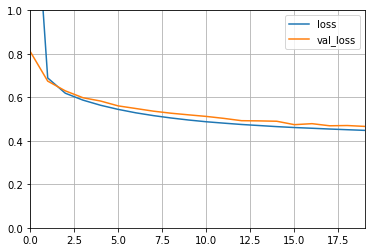

In [89]:
pd.DataFrame(history.history).plot()
plt.grid(True) # 是否加上网格
plt.gca().set_ylim(0,1)
plt.show()

In [90]:
y_pred = model.predict((x_new_A,x_new_B))

In [91]:
y_pred

array([[3.592194  ],
       [1.4298158 ],
       [0.63381064]], dtype=float32)

In [92]:
y_test[:3]

array([2.544, 0.992, 0.728])

有以下要使用多输入的场景：

任务要求。例如，你想定位和分类图片中的主要物体。这既是一个回归任务（找到目标中心的坐标、宽度和高度）和分类任务。

相似的，对于相同的数据，你可能有多个独立的任务。当然可以每个任务训练一个神经网络，`但在多数情况下，同时对所有任务训练一个神经网络，每个任务一个输出，后者的效果更好。`这是因为神经网络可以在不同任务间学习有用的数据特征。例如，在人脸的多任务分类时，你可以用一个输出做人物表情的分类（微笑惊讶等等），用另一个输出判断是否戴着眼镜。

另一种情况是作为一种正则的方法（即，一种降低过拟合和提高泛化能力的训练约束）。`例如，你想在神经网络中加入一些辅助输出（见图 10-16），好让神经网络的一部分依靠自身就能学到一些东西。`

<div align=center><img  src="./static/使用函数式 API 搭建复杂模型3.jpg"/></div>


添加额外的输出很容易：只需要将输出和相关的层连起来、将输出写入输出列表就行。例如，下面的代码搭建的就是上图的架构：

In [93]:
input_A = keras.layers.Input(shape=[5],name='wide_input')
input_B = keras.layers.Input(shape=[6],name='deep_input')
hidden1 = keras.layers.Dense(30,activation='relu')(input_B)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A,hidden2])
output = keras.layers.Dense(1,name = 'main_output')(concat)
aux_output = keras.layers.Dense(1,name = 'aux_output')(hidden2)
model = keras.Model(inputs = [input_A,input_B],outputs = [output,aux_output])

每个输出都要有自己的损失函数。因此在编译模型时，需要传入损失列表（如果只传入一个损失，Keras 会认为所有输出是同一个损失函数）。Keras 默认计算所有损失，将其求和得到最终损失用于训练。主输出比辅助输出更值得关心，所以要提高它的权重，如下所示：

In [94]:
model.compile(loss=['mse','mse'],loss_weights=[0.9,0.1],optimizer='sgd')

此时若要训练模型，必须给每个输出贴上标签。在这个例子中，主输出和辅输出预测的是同一件事，因此标签相同。传入数据必须是 `(y_train, y_train)（y_valid和y_test也是如此）`：

In [95]:
history = model.fit((x_train_A,x_train_B),(y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9572 - main_output_loss: 0.8493 - aux_output_loss: 1.9274 - val_loss: 0.6132 - val_main_output_loss: 0.5608 - val_aux_output_loss: 1.0848
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5572 - main_output_loss: 0.5142 - aux_output_loss: 0.9443 - val_loss: 0.5476 - val_main_output_loss: 0.5121 - val_aux_output_loss: 0.8674
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5094 - main_output_loss: 0.4742 - aux_output_loss: 0.8262 - val_loss: 0.5049 - val_main_output_loss: 0.4747 - val_aux_output_loss: 0.7766
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4874 - main_output_loss: 0.4583 - aux_output_loss: 0.7488 - val_loss: 0.4823 - val_main_output_loss: 0.4567 - val_aux_output_loss: 0.7131
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4655 - main_output_loss: 0.4405 - aux_output_loss: 0.6909 - val_loss

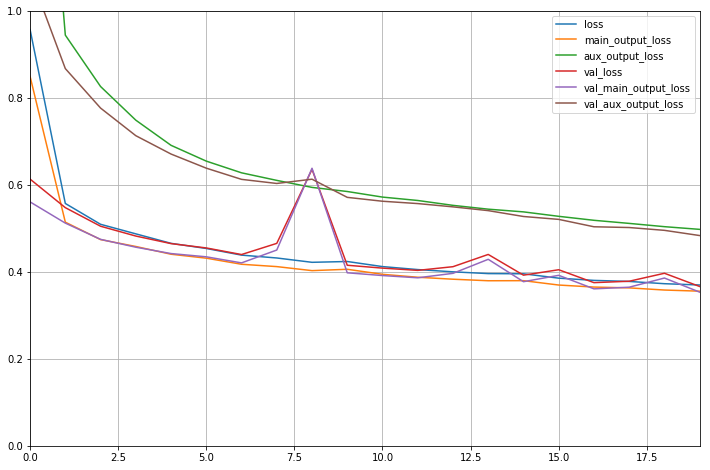

In [96]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.ylim(0,1)
plt.show()

当评估模型时，Keras 会返回总损失和各个损失值：

In [97]:
total_loss,main_loss,aux_loss = model.evaluate((x_test_A,x_test_B),(y_test,y_test))

162/162 [==============================] - 0s 954us/step - loss: 0.3885 - main_output_loss: 0.3747 - aux_output_loss: 0.5124


相似的，方法 `predict()` 会返回每个输出的预测值：

In [98]:
y_pred_main,y_pred_aux = model.predict([x_new_A,x_new_B])

In [99]:
y_pred_main

array([[3.5575905],
       [1.2594657],
       [0.6264191]], dtype=float32)

In [100]:
y_pred_aux

array([[2.8485675],
       [1.2711855],
       [1.0115352]], dtype=float32)

可以看到，用函数式 API 可以轻易搭建任意架构。接下来再看最后一种搭建 Keras 模型的方法。

### 9、使用子类化 API 搭建动态模型

顺序 API 和函数式 API 都是声明式的：只有声明创建每个层以及层的连接方式，才能给模型加载数据以进行训练和推断。这种方式有其优点：模型可以方便的进行保存、克隆和分享；模型架构得以展示，便于分析；框架可以推断数据形状和类型，便于及时发现错误（加载数据之前就能发现错误）。调试也很容易，因为模型是层的静态图。但是缺点也很明显：模型是静态的。一些模型包含循环、可变数据形状、条件分支，和其它的动态特点。对于这些情况，或者你只是喜欢命令式编程，不妨使用子类化 API。

对 `Model` 类划分子类，在构造器中创建需要的层，调用 `call()` 进行计算。例如，创建一个下面的 `WideAndDeepModel` 类的实例，就可以创建与前面函数式 `API` 例子的同样模型，同样可以进行编译、评估、预测：

In [101]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

# model = WideAndDeepModel() 

这个例子和函数式 API 很像，除了不用创建输入；只需要在 `call()` 使用参数 `input` ，另外的不同是将层的创建和和使用分割了。最大的差别是，在`call()` 方法中，你可以做任意想做的事：for循环、if语句、低级的 TensorFlow 操作，可以尽情发挥想象（见第 12 章）！子类化 API 可以让研究者试验各种新创意。

然而代价也是有的：模型架构隐藏在 `call()` 方法中，所以 Keras 不能对其检查；`不能保存或克隆`；当调用 `summary()` 时，得到的只是层的列表，没有层的连接信息。另外，Keras 不能提前检查数据类型和形状，所以很容易犯错。所以除非真的需要灵活性，还是使用顺序 API 或函数式 API 吧。

#### 提示：

可以像常规层一样使用 Keras 模型，组合模型搭建任意复杂的架构。

In [102]:
# model.call([keras.layers.Input(shape=[5],name='wide_input'),keras.layers.Input(shape=[6],name='deep_input')])

In [103]:
# model.compile(loss=['mse','mse'],loss_weights=[0.9,0.1],optimizer='sgd')

In [104]:
# history = model.fit((x_train_A,x_train_B),(y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)))

In [105]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 30)           930         dense_13[0][0]                   
____________________________________________________________________________________________

### 10、保存和恢复模型

使用顺序 API 或函数式 API 时，保存训练好的 Keras 模型和训练一样简单：

In [106]:
# model = keras.layers.Sequential([...]) # or keras.Model([...])
# model.compile([...])
# model.fit([...])
model.save("my_keras_model.h5") 

Keras 使用 HDF5 格式保存模型架构（包括每层的超参数）和每层的所有参数值（连接权重和偏置项）。还保存了优化器（包括超参数和状态）。

通常用脚本训练和保存模型，一个或更多的脚本（或 web 服务）来加载模型和做预测。加载模型很简单：

In [107]:
model = keras.models.load_model("my_keras_model.h5") 

#### 警告：

这种加载模型的方法只对顺序 API 或函数式 API 有用，不适用于子类化 API。对于后者，可以用 save_weights() 和 load_weights() 保存参数，其它的就得手动保存恢复了。

但如果训练要持续数个小时呢？在大数据集上训练，训练时间长很普遍。此时，不仅要在训练结束时保存模型检查点，在一定时间间隔内也要保存，以免电脑宕机造成损失。但是如何告诉 `fit()` 保存检查点呢？ `使用调回`。

### 11、使用调回

`fit()` 方法接受参数 `callbacks` ，可以让用户指明一个 Keras 列表，让 Keras 在训练开始和结束、每个周期开始和结束、甚至是每个批次的前后调用。例如，`ModelCheckpoint` 可以在每个时间间隔保存检查点，默认是每个周期结束之后：

In [108]:
# [...] # 搭建编译模型
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = model.fit((x_train_A,x_train_B), (y_train,y_train), epochs=20, callbacks=[checkpoint_cb]) 

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3656 - main_output_loss: 0.3517 - aux_output_loss: 0.4908
Epoch 2/20
363/363 [==============================] - 0s 950us/step - loss: 0.3646 - main_output_loss: 0.3513 - aux_output_loss: 0.4850
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3595 - main_output_loss: 0.3462 - aux_output_loss: 0.4794
Epoch 4/20
363/363 [==============================] - 0s 981us/step - loss: 0.3562 - main_output_loss: 0.3431 - aux_output_loss: 0.4738
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3536 - main_output_loss: 0.3410 - aux_output_loss: 0.4669
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3534 - main_output_loss: 0.3412 - aux_output_loss: 0.4640
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3484 - main_output_loss: 0.3363 - aux_output_loss: 0.4571
Epoch 8/20
363/363 [==============================] - 0s 1

另外，如果训练时使用了验证集，可以在创建检查点时设定 `save_best_only=True`，只有当模型在验证集上取得最优值时才保存模型。这么做可以不必担心训练时间过长和训练集过拟合：只需加载训练好的模型，就能保证是在验证集上表现最好的模型。下面的代码演示了早停（见第 4 章）：

In [109]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5',save_best_only=True)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5') # roll back to best model 

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3326 - main_output_loss: 0.3233 - aux_output_loss: 0.4164 - val_loss: 0.3395 - val_main_output_loss: 0.3316 - val_aux_output_loss: 0.4102
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3311 - main_output_loss: 0.3218 - aux_output_loss: 0.4149 - val_loss: 0.5922 - val_main_output_loss: 0.5938 - val_aux_output_loss: 0.5778
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3335 - main_output_loss: 0.3247 - aux_output_loss: 0.4122 - val_loss: 0.3291 - val_main_output_loss: 0.3212 - val_aux_output_loss: 0.4000
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3279 - main_output_loss: 0.3189 - aux_output_loss: 0.4083 - val_loss: 0.3344 - val_main_output_loss: 0.3273 - val_aux_output_loss: 0.3984
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3297 - main_output_loss: 0.3208 - aux_output_loss: 0.4103 - val_loss

另一种实现早停的方法是使用 `EarlyStopping` 调回。当检测到经过几个周期（周期数由参数 `patience` 确定），验证集表现没有提升时，就会中断训练，还能自动滚回到最优模型。可以将保存检查点（避免宕机）和早停（避免浪费时间和资源）结合起来：

In [110]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=50,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
363/363 [==============================] - 1s 2ms/step - loss: 0.3174 - main_output_loss: 0.3096 - aux_output_loss: 0.3875 - val_loss: 0.3272 - val_main_output_loss: 0.3208 - val_aux_output_loss: 0.3851
Epoch 2/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3158 - main_output_loss: 0.3081 - aux_output_loss: 0.3852 - val_loss: 0.3198 - val_main_output_loss: 0.3134 - val_aux_output_loss: 0.3775
Epoch 3/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3162 - main_output_loss: 0.3085 - aux_output_loss: 0.3850 - val_loss: 0.3248 - val_main_output_loss: 0.3173 - val_aux_output_loss: 0.3926
Epoch 4/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3159 - main_output_loss: 0.3082 - aux_output_loss: 0.3853 - val_loss: 0.3314 - val_main_output_loss: 0.3247 - val_aux_output_loss: 0.3920
Epoch 5/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3161 - main_output_loss: 0.3086 - aux_output_loss: 0.3833 - val_loss

363/363 [==============================] - 0s 1ms/step - loss: 0.3020 - main_output_loss: 0.2954 - aux_output_loss: 0.3607 - val_loss: 0.3170 - val_main_output_loss: 0.3108 - val_aux_output_loss: 0.3731
Epoch 40/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2998 - main_output_loss: 0.2933 - aux_output_loss: 0.3582 - val_loss: 0.3309 - val_main_output_loss: 0.3258 - val_aux_output_loss: 0.3768
Epoch 41/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2988 - main_output_loss: 0.2922 - aux_output_loss: 0.3576 - val_loss: 0.3171 - val_main_output_loss: 0.3115 - val_aux_output_loss: 0.3673
Epoch 42/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2996 - main_output_loss: 0.2932 - aux_output_loss: 0.3579 - val_loss: 0.3177 - val_main_output_loss: 0.3120 - val_aux_output_loss: 0.3691


如果还想有其它操控，还可以编写自定义的调回。下面的例子展示了一个可以展示验证集损失和训练集损失比例的自定义（检测过拟合）调回：

In [111]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"])) 

类似的，还可以实现 `on_train_begin()` 、`on_train_end()`、`on_epoch_begin()`、`on_epoch_end()`、`on_batch_begin()`、和 `on_batch_end()` 。如果需要的话，在评估和预测时也可以使用调回（例如为了调试）。对于评估，可以实现 `on_test_begin()`、`on_test_end()`、`on_test_batch_begin()`或 `on_test_batch_end()`（通过 `evaluate()`调用）；对于预测，可以实现 `on_predict_begin()`、`on_predict_end()`、`on_predict_batch_begin()` 或`on_predict_batch_end()`（通过 `predict()` 调用）。

下面来看一个使用 `tf.keras`的必备工具：`TensorBoard` 。

### 11、使用 TensorBoard 进行可视化

`TensorBoard` 是一个强大的交互可视化工具，使用它可以查看训练过程中的学习曲线、比较每次运行的学习曲线、可视化计算图、分析训练数据、查看模型生成的图片、可视化投射到 3D 的多维数据，等等。`TensorBoard` 是 `TensorFlow` 自带的。

要使用 `TensorBoard`，必须修改程序，将要可视化的数据输出为二进制的日志文件 `event files` 。每份二进制数据称为摘要 `summary` ，`TensorBoard` 服务器会监测日志文件目录，自动加载更新并可视化：这样就能看到实时数据（稍有延迟），比如训练时的学习曲线。通常，将 TensorBoard 服务器指向根日志目录，程序的日志写入到它的子目录，这样一个 TensorBoard 服务就能可视化并比较多次运行的数据，而不会将其搞混。

我们先定义 TensorBoard 的根日志目录，还有一些根据当前日期生成子目录的小函数。你可能还想在目录名中加上其它信息，比如超参数的值，方便知道查询的内容：

In [113]:
import os

In [114]:
os.curdir

'.'

In [116]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22' 

In [117]:
root_logdir

'.\\my_logs'

Keras 提供了一个 `TensorBoard()` 调回：

In [118]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=50,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[tensorboard_cb])

Epoch 1/50
363/363 [==============================] - 2s 6ms/step - loss: 0.3018 - main_output_loss: 0.2952 - aux_output_loss: 0.3612 - val_loss: 0.3211 - val_main_output_loss: 0.3145 - val_aux_output_loss: 0.3798
Epoch 2/50
363/363 [==============================] - 1s 2ms/step - loss: 0.3010 - main_output_loss: 0.2944 - aux_output_loss: 0.3606 - val_loss: 0.3301 - val_main_output_loss: 0.3255 - val_aux_output_loss: 0.3717
Epoch 3/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3020 - main_output_loss: 0.2954 - aux_output_loss: 0.3616 - val_loss: 0.3151 - val_main_output_loss: 0.3101 - val_aux_output_loss: 0.3601
Epoch 4/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3023 - main_output_loss: 0.2959 - aux_output_loss: 0.3605 - val_loss: 0.3170 - val_main_output_loss: 0.3110 - val_aux_output_loss: 0.3713
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 0.3005 - main_output_loss: 0.2940 - aux_output_loss: 0.3596 - val_loss

363/363 [==============================] - 1s 2ms/step - loss: 0.2918 - main_output_loss: 0.2856 - aux_output_loss: 0.3479 - val_loss: 0.3228 - val_main_output_loss: 0.3172 - val_aux_output_loss: 0.3730
Epoch 40/50
363/363 [==============================] - 1s 2ms/step - loss: 0.2911 - main_output_loss: 0.2849 - aux_output_loss: 0.3467 - val_loss: 0.3117 - val_main_output_loss: 0.3077 - val_aux_output_loss: 0.3480
Epoch 41/50
363/363 [==============================] - 1s 2ms/step - loss: 0.2921 - main_output_loss: 0.2859 - aux_output_loss: 0.3475 - val_loss: 0.3013 - val_main_output_loss: 0.2961 - val_aux_output_loss: 0.3481
Epoch 42/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2923 - main_output_loss: 0.2863 - aux_output_loss: 0.3468 - val_loss: 0.3183 - val_main_output_loss: 0.3136 - val_aux_output_loss: 0.3606
Epoch 43/50
363/363 [==============================] - 1s 2ms/step - loss: 0.2908 - main_output_loss: 0.2846 - aux_output_loss: 0.3463 - val_loss: 0.328

简直不能再简单了。如果运行这段代码，TensorBoard()调回会负责创建日志目录（包括父级目录），在训练过程中会创建事件文件并写入概要。再次运行程序（可能修改了一些超参数）之后，得到的目录结构可能如下：

    my_logs/
    ├── run_2019_06_07-15_15_22
    │   ├── train
    │   │   ├── events.out.tfevents.1559891732.mycomputer.local.38511.694049.v2
    │   │   ├── events.out.tfevents.1559891732.mycomputer.local.profile-empty
    │   │   └── plugins/profile/2019-06-07_15-15-32
    │   │       └── local.trace
    │   └── validation
    │       └── events.out.tfevents.1559891733.mycomputer.local.38511.696430.v2
    └── run_2019_06_07-15_15_49
        └── [...] 


每次运行都会创建一个目录，每个目录都有一个包含训练日志和验证日志的子目录。两者都包括事件文件，训练日志还包括分析追踪信息：它可以让 TensorBoard 展示所有设备上的模型的各个部分的训练时长，有助于定位性能瓶颈。

然后就可以启动 TensorBoard 服务了。一种方式是通过运行命令行。如果是在虚拟环境中安装的 TensorFlow，需要激活虚拟环境。接着，在根目录（也可以是其它路径，但一定要指向日志目录）运行下面的命令：

    $ tensorboard --logdir=./my_logs --port=6006
    TensorBoard 2.0.0 at http://mycomputer.local:6006/ (Press CTRL+C to quit) 


无论是使用哪种方式，都得使用 TensorBoard 的浏览器界面。点击栏SCALARS可以查看学习曲线（见图 ）。左下角选择想要可视化的路径（比如第一次和第二次运行的训练日志），再点击epoch_loss。可以看到，在两次训练过程中，训练损失都是下降的，但第二次下降的更快。事实上，第二次的学习率是 `0.05`（optimizer=keras.optimizers.SGD(lr=0.05)）而不是 `0.001`。

<div align=center><img  src="./static/tensorboard.jpg"/></div>


In [ ]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step) 

总结一下目前所学：神经网络的起源、MLP 是什么、如何用 MLP 做分类和回归、如何使用顺序 API 搭建 MLP、如何使用函数式 API 或子类化 API 搭建更复杂的模型架构、保存和恢复模型、如何使用调回创建检查点、早停，等等。最后，学了使用 TensorBoard 做可视化。这些知识已经足够解决许多问题了。但是，你可能还有疑问，如何选择隐藏层的层数、神经元的数量，以及其他的超参数，下面就来讨论这些问题。

### 11、微调神经网络的超参数

神经网络的灵活性同时也是它的缺点：要微调的超参数太多了。不仅架构可能不同，就算对于一个简单的 MLP，就可以调节层数、每层的神经元数、每层使用什么激活函数、初始化的权重，等等。怎么才能知道哪个超参数的组合才是最佳的呢？

一种方法是直接试验超参数的组合，看哪一个在验证集（或使用 K 折交叉验证）的表现最好。例如，可以使用 `GridSearchCV` 或 `RandomizedSearchCV` 探索超参数空间，就像第 2 章中那样。要这么做的话，必须将 Keras 模型包装进模仿 Scikit-Learn 回归器的对象中。第一步是给定一组超参数，创建一个搭建和编译 Keras 模型的函数：

In [119]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model 

这个函数创建了一个单回归（只有一个输出神经元）顺序模型，数据形状、隐藏层的层数和神经元数是给定的，使用指定学习率的SGD优化器编译。最好尽量给大多数超参数都设置合理的默认值，就像 Scikit-Learn 那样。

然后使用函数 `build_model()` 创建一个 `KerasRegressor` ：

In [120]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

In [122]:
keras_reg.summary()

AttributeError: 'KerasRegressor' object has no attribute 'summary'

`KerasRegressor` 是通过 `build_model()` 将 Keras 模型包装起来的。因为在创建时没有指定任何超参数，使用的是 `build_model()` 的默认参数。现在就可以像常规的 Scikit-Learn 回归器一样来使用它了：使用 `fit()` 方法训练，使用 `score()` 方法评估，使用 `predict()` 方法预测，见下面代码：

In [124]:
keras_reg.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid),callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(x_test,y_test)
y_pred = keras_reg.predict(x_new)

D:\APYPLA~1\venv_dir\venv1\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.3381 - val_loss: 0.7949
Epoch 2/20
363/363 [==============================] - 0s 868us/step - loss: 0.7066 - val_loss: 0.6839
Epoch 3/20
363/363 [==============================] - ETA: 0s - loss: 0.615 - 0s 995us/step - loss: 0.6098 - val_loss: 0.6078
Epoch 4/20
363/363 [==============================] - 0s 838us/step - loss: 0.5483 - val_loss: 0.5547
Epoch 5/20
363/363 [==============================] - 0s 917us/step - loss: 0.5058 - val_loss: 0.5345
Epoch 6/20
363/363 [==============================] - 0s 917us/step - loss: 0.4851 - val_loss: 0.5083
Epoch 7/20
363/363 [==============================] - 0s 989us/step - loss: 0.4674 - val_loss: 0.4884
Epoch 8/20
363/363 [==============================] - 0s 849us/step - loss: 0.4607 - val_loss: 0.4792
Epoch 9/20
363/363 [==============================] - 0s 984us/step - loss: 0.4512 - val_loss: 0.4900
Epoch 10/20
363/363 [==============================] - 0s 81

通过使用 `scipy.stat.Reciprocal()` 方法，我们可以使用该方法获得表示倒数分布的连续随机变量。 

In [126]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [135]:
r = reciprocal(3e-4, 3e-2)

In [141]:
r.ppf(0.3)

0.00030000013815513737

In [142]:
?RandomizedSearchCV

In [143]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg,param_distribs,n_iter=10,cv =3)
rnd_search_cv.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid),callbacks = [keras.callbacks.EarlyStopping(patience=10)])

D:\APYPLA~1\venv_dir\venv1\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 3.6450 - val_loss: 2.4804
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 1.7754 - val_loss: 1.4899
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 1.1481 - val_loss: 1.0815
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8952 - val_loss: 0.8894
Epoch 5/20
242/242 [==============================] - 0s 972us/step - loss: 0.7813 - val_loss: 0.7961
Epoch 6/20
242/242 [==============================] - 0s 968us/step - loss: 0.7258 - val_loss: 0.7481
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6957 - val_loss: 0.7202
Epoch 8/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6768 - val_loss: 0.7018
Epoch 9/20
242/242 [==============================] - 0s 972us/step - loss: 0.6628 - val_loss: 0.6881
Epoch 10/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6513 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 137880.4219 - val_loss: 716.5468
Epoch 7/20
242/242 [==============================] - 0s 943us/step - loss: 4016.1594 - val_loss: 2291.7817
Epoch 8/20
242/242 [==============================] - 0s 999us/step - loss: 10929.1885 - val_loss: 5497.6763
Epoch 9/20
242/242 [==============================] - 0s 1ms/step - loss: 416740.5938 - val_loss: 17367.1816
Epoch 10/20
242/242 [==============================] - 0s 1ms/step - loss: 480356.5000 - val_loss: 37254.3945
Epoch 11/20
121/121 [==============================] - 0s 621us/step - loss: 25647.0215
Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 0.9313 - val_loss: 0.5698
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5250 - val_loss: 0.5351
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5128 - val_loss: 0.5949
Epoch 4/20
242/242 [==============================] - 0s 956us/step - loss: 0.50

121/121 [==============================] - 0s 601us/step - loss: 1.1851
Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 2.7712 - val_loss: 1.3397
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 0.9259 - val_loss: 0.7887
Epoch 3/20
242/242 [==============================] - 0s 967us/step - loss: 0.6746 - val_loss: 0.6878
Epoch 4/20
242/242 [==============================] - 0s 966us/step - loss: 0.6171 - val_loss: 0.6482
Epoch 5/20
242/242 [==============================] - 0s 979us/step - loss: 0.5894 - val_loss: 0.6233
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5702 - val_loss: 0.6070
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5552 - val_loss: 0.5941
Epoch 8/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5439 - val_loss: 0.5831
Epoch 9/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5345 - val_loss: 0.5758
Epoch 10/20
242/242 [=

242/242 [==============================] - 0s 926us/step - loss: 0.5014 - val_loss: 0.5624
Epoch 18/20
242/242 [==============================] - 0s 999us/step - loss: 0.5016 - val_loss: 0.5676
Epoch 19/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5015 - val_loss: 0.5715
Epoch 20/20
121/121 [==============================] - 0s 628us/step - loss: 0.5538
Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 1.8296 - val_loss: 0.6879
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5773 - val_loss: 0.5740
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5379 - val_loss: 0.5581
Epoch 4/20
242/242 [==============================] - 0s 895us/step - loss: 0.5308 - val_loss: 0.5565
Epoch 5/20
242/242 [==============================] - 0s 910us/step - loss: 0.5264 - val_loss: 0.5619
Epoch 6/20
242/242 [==============================] - 0s 981us/step - loss: 0.5223 - val_loss: 0.5598
Epoch 7/20
242/

242/242 [==============================] - 0s 953us/step - loss: 0.5337 - val_loss: 0.5638
Epoch 16/20
242/242 [==============================] - 0s 926us/step - loss: 0.5316 - val_loss: 0.5632
Epoch 17/20
242/242 [==============================] - 0s 947us/step - loss: 0.5296 - val_loss: 0.5616
Epoch 18/20
242/242 [==============================] - 0s 896us/step - loss: 0.5277 - val_loss: 0.5608
Epoch 19/20
242/242 [==============================] - 0s 969us/step - loss: 0.5261 - val_loss: 0.5596
Epoch 20/20
121/121 [==============================] - 0s 586us/step - loss: 0.5369
Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 3.4404 - val_loss: 2.0217
Epoch 2/20
242/242 [==============================] - 0s 993us/step - loss: 1.4140 - val_loss: 1.0122
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8234 - val_loss: 0.7086
Epoch 4/20
242/242 [==============================] - 0s 926us/step - loss: 0.6404 - val_loss: 0.6115
Epoch 5/2

242/242 [==============================] - 0s 930us/step - loss: 0.5621 - val_loss: 0.5831
Epoch 13/20
242/242 [==============================] - 0s 923us/step - loss: 0.5599 - val_loss: 0.5823
Epoch 14/20
242/242 [==============================] - 0s 931us/step - loss: 0.5579 - val_loss: 0.5812
Epoch 15/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5561 - val_loss: 0.5783
Epoch 16/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5544 - val_loss: 0.5792
Epoch 17/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5528 - val_loss: 0.5780
Epoch 18/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5513 - val_loss: 0.5773
Epoch 19/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5500 - val_loss: 0.5761
Epoch 20/20
121/121 [==============================] - 0s 831us/step - loss: 0.5100
Epoch 1/20
242/242 [==============================] - 1s 2ms/step - loss: 0.9303 - val_loss: 0.5158
Epoch 2/20
242

121/121 [==============================] - 0s 673us/step - loss: 0.3871
Epoch 1/20
242/242 [==============================] - 1s 2ms/step - loss: 1.0271 - val_loss: 0.6669
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5967 - val_loss: 0.5657
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5159 - val_loss: 0.5142
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.4714 - val_loss: 0.4806
Epoch 5/20
242/242 [==============================] - 0s 1ms/step - loss: 0.4320 - val_loss: 0.4404
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.4131 - val_loss: 0.4217
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.3996 - val_loss: 0.4129
Epoch 8/20
242/242 [==============================] - 0s 963us/step - loss: 0.3970 - val_loss: 0.4092
Epoch 9/20
242/242 [==============================] - 0s 1ms/step - loss: 0.3838 - val_loss: 0.3978
Epoch 10/20
242/242 [=====

242/242 [==============================] - 0s 1ms/step - loss: 0.4209 - val_loss: 0.4407
Epoch 20/20
121/121 [==============================] - 0s 727us/step - loss: 0.4324
Epoch 1/20
242/242 [==============================] - 1s 2ms/step - loss: 2.2955 - val_loss: 1.0346
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8310 - val_loss: 0.7724
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7290 - val_loss: 0.7080
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6859 - val_loss: 0.6707
Epoch 5/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6530 - val_loss: 0.6418
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6251 - val_loss: 0.6197
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6014 - val_loss: 0.6001
Epoch 8/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5808 - val_loss: 0.5782
Epoch 9/20
242/242 [=======

D:\APYPLA~1\venv_dir\venv1\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


363/363 [==============================] - 1s 1ms/step - loss: 0.8149 - val_loss: 0.5718
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5022 - val_loss: 0.4820
Epoch 3/20
363/363 [==============================] - 0s 991us/step - loss: 0.4488 - val_loss: 0.4505
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4232 - val_loss: 0.4348
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.4159
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3962 - val_loss: 0.4038
Epoch 7/20
363/363 [==============================] - 0s 983us/step - loss: 0.3867 - val_loss: 0.3953
Epoch 8/20
363/363 [==============================] - 0s 909us/step - loss: 0.3806 - val_loss: 0.3888
Epoch 9/20
363/363 [==============================] - 0s 915us/step - loss: 0.3707 - val_loss: 0.3866
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.3857
Ep

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F0BE7F7908>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F0C1152128>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 1...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_

所做的和第 2 章差不多，除了这里试讲参数传给 `fit()` ，`fit()` 再传给底层的 Keras。注意，RandomizedSearchCV使用的是 K 折交叉验证，没有用 `X_valid` 和 `y_valid`（只有早停时才使用）。

In [144]:
rnd_search_cv.best_params_

{'learning_rate': 0.0048049691964912366, 'n_hidden': 3, 'n_neurons': 35}

In [145]:
rnd_search_cv.best_score_

-0.42823247114817303

In [146]:
model = rnd_search_cv.best_estimator_.model # best_estimator_ 获取指定的参数在模型中的最优估计量

现在就可以保存模型、在测试集上评估，如果对效果满意，就可以部署了。使用随机搜索并不难，适用于许多相对简单的问题。但是当训练较慢时（大数据集的复杂问题），这个方法就只能探索超参数空间的一小部分而已。通过手动调节可以缓解一下：首先使用大范围的超参数值先做一次随机搜索，然后根据第一次的结果再做一次小范围的计算，以此类推。这样就能缩放到最优超参数的范围了。但是，这么做很耗时。

幸好，有比随机搜索更好的探索超参数空间的方法。核心思想很简单：当某块空间的区域表现好时，就多探索这块区域。这些方法可以代替用户做“放大”工作，可以在更短的时间得到更好的结果。下面是一些可以用来优化超参数的 Python 库：

Hyperopt 一个可以优化各种复杂搜索空间（包括真实值，比如学习率和离散值，比如层数）的库。

Hyperas，kopt 或 Talos 用来优化 Keras 模型超参数的库（前两个是基于 Hyperopt 的）。

Keras Tuner Google 开发的简单易用的 Keras 超参数优化库，还有可视化和分析功能。

Scikit-Optimize (skopt) 一个通用的优化库。类BayesSearchCV使用类似于GridSearchCV的接口做贝叶斯优化。

Spearmint 一个贝叶斯优化库。

Hyperband 一个快速超参数调节库，基于 Lisha Li 的论文《Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization》。

Sklearn-Deap 一个基于进化算法的超参数优化库，接口类似GridSearchCV。

另外，许多公司也提供超参数优化服务。第 19 章会讨论 Google Cloud AI 平台的超参数调节服务。其它公司有 Arimo 、 SigOpt，和 CallDesk 的 Oscar.

超参数调节仍然是活跃的研究领域，其中进化算法表现很突出。例如，在 2017 年的论文《Population Based Training of Neural Networks》中，Deepmind 的作者用统一优化了一组模型及其超参数。Google 也使用了一种进化算法，不仅用来搜索查参数，还可以搜索最佳的神经网络架构；Google 的 AutoML 套间已经可以在云服务上使用了。也许手动搭建神经网络的日子就要结束了？看看 Google 的这篇文章。事实上，用进化算法训练独立的神经网络很成功，已经取代梯度下降了。例如，Uber 在 2017 年介绍了名为 Deep Neuroevolution 的技术，见这里。

尽管有这些工具和服务，知道每个超参数该取什么值仍然是帮助的，可以快速创建原型和收缩搜索范围。后面的文字介绍了选择 MLP 隐藏层数和神经元数的原则，以及如何选择主要的超参数值。

https://hands1ml.apachecn.org/#/docs/10?id=%e5%be%ae%e8%b0%83%e7%a5%9e%e7%bb%8f%e7%bd%91%e7%bb%9c%e7%9a%84%e8%b6%85%e5%8f%82%e6%95%b0

### 12、隐藏层数

对于许多问题，开始时只用一个隐藏层就能得到不错的结果。只要有足够多的神经元，只有一个隐藏层的 MLP 就可以对复杂函数建模。但是对于复杂问题，深层网络比浅层网络有更高的参数效率：深层网络可以用指数级别更少的神经元对复杂函数建模，因此对于同样的训练数据量性能更好。

要明白为什么，假设别人让你用绘图软件画一片森林，但你不能复制和粘贴。这样的话，就得花很长时间，你需要手动来画每一棵树，一个树枝然后一个树枝，一片叶子然后一片叶子。如果可以鲜花一片叶子，然后将叶子复制粘贴到整个树枝上，再将树枝复制粘贴到整棵树上，然后再复制树，就可以画出一片森林了，所用的时间可以大大缩短。`真实世界的数据通常都是有层次化结构的，深层神经网络正式利用了这一点：浅隐藏层对低级结构（比如各种形状的线段和方向），中隐藏层结合这些低级结构对中级结构（方，圆）建模，深隐藏层和输出层结合中级结构对高级结构（比如，脸）建模。`

`层级化的结构不仅帮助深度神经网络收敛更快，，也提高了对新数据集的泛化能力。例如，如果已经训练好了一个图片人脸识别的模型，现在想训练一个识别发型的神经网络，你就可以复用第一个网络的浅层。不用随机初始化前几层的权重和偏置项，而是初始化为第一个网络浅层的权重和偏置项。这样，网络就不用从多数图片的低级结构开始学起；只要学高级结构（发型）就行了。这就称为迁移学习。`

概括来讲，对于许多问题，神经网络只有一或两层就够了。例如，只用一个隐藏层和几百个神经元，就能在 MNIST 上轻松达到 97% 的准确率；同样的神经元数，两个隐藏层，训练时间几乎相同，就能达到 98% 的准确率。对于更复杂的问题，可以增加隐藏层的数量，直到在训练集上过拟合为止。非常复杂的任务，比如大图片分类或语音识别，神经网络通常需要几十层（甚至上百，但不是全连接的，见第 14 章），需要的训练数据量很大。对于这样的网络，很少是从零训练的：常见的是使用预训练好的、表现出众的任务相近的网络，训练可以快得多，需要的数据也可以不那么多（见第 11 章的讨论）。

### 13、每个隐藏层的神经元数

实际中，通常的简便而高效的方法是使用层数和神经元数都超量的模型，然后使用早停和其它正则技术防止过拟合。一位 Google 的科学家 Vincent Vanhoucke，称这种方法为“弹力裤”：不浪费时间选择尺寸完美匹配的裤子，而是选择一条大的弹力裤，它能自动收缩到合适的尺寸。通过这种方法，可以避免影响模型的瓶颈层。另一方面，如果某层的神经元太少，就没有足够强的表征能力，保存所有的输入信息（比如，只有两个神经元的的层只能输出 2D 数据，如果用它处理 3D 数据，就会丢失信息）。无论模型网络的其它部分如何强大，丢失的信息也找不回来了。

#### 提示：

通常，增加层数比增加每层的神经元的收益更高。

### 14、学习率，批次大小和其它超参数

https://hands1ml.apachecn.org/#/docs/10?id=%e5%ad%a6%e4%b9%a0%e7%8e%87%ef%bc%8c%e6%89%b9%e6%ac%a1%e5%a4%a7%e5%b0%8f%e5%92%8c%e5%85%b6%e5%ae%83%e8%b6%85%e5%8f%82%e6%95%b0